https://stackoverflow.com/questions/51903350/python-vs-matlab-performance-on-algorithm

First we measure the scaling of the serial implementation

_Performance enhancement 1_: use Numba within a single array

In [1]:
!hostname

de85d077fb1c


In [2]:
import numpy as np
import time
import matplotlib.pyplot as plt

For Numpy, set how floating-point errors are handled.
    
https://docs.scipy.org/doc/numpy/reference/generated/numpy.seterr.html

In [3]:
np.seterr(divide='ignore', invalid='ignore')

{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

# original code to be profiled optimized
The following is merely a computationally expective function

In [4]:
# https://github.com/nikdon/pyEntropy
def sample_entropy(time_series, sample_length, tolerance=None):
    """Calculate and return Sample Entropy of the given time series.
    Distance between two vectors defined as Euclidean distance and can
    be changed in future releases
    Args:
        time_series: Vector or string of the sample data
        sample_length: Number of sequential points of the time series
        tolerance: Tolerance (default = 0.1...0.2 * std(time_series))
    Returns:
        Vector containing Sample Entropy (float)
    References:
        [1] http://en.wikipedia.org/wiki/Sample_Entropy
        [2] http://physionet.incor.usp.br/physiotools/sampen/
        [3] Madalena Costa, Ary Goldberger, CK Peng. Multiscale entropy analysis
            of biological signals
    """
    if tolerance is None:
        tolerance = 0.1 * np.std(time_series)

    n = len(time_series)
    prev = np.zeros(n)
    curr = np.zeros(n)
    A = np.zeros((sample_length, 1))  # number of matches for m = [1,...,template_length - 1]
    B = np.zeros((sample_length, 1))  # number of matches for m = [1,...,template_length]

    for i in range(n - 1):
        nj = n - i - 1
        ts1 = time_series[i]
        for jj in range(nj):
            j = jj + i + 1
            if abs(time_series[j] - ts1) < tolerance:  # distance between two vectors
                curr[jj] = prev[jj] + 1
                temp_ts_length = min(sample_length, curr[jj])
                for m in range(int(temp_ts_length)):
                    A[m] += 1
                    if j < n - 1:
                        B[m] += 1
            else:
                curr[jj] = 0
        for j in range(nj):
            prev[j] = curr[j]

    N = n * (n - 1) / 2
    B = np.vstack(([N], B[:sample_length - 1]))
    similarity_ratio = A / B
    se = - np.log(similarity_ratio)
    se = np.reshape(se, -1)
    return se

# profile code

In order to optimize effectively, need to understand where hot spots are


## function profiling
Conclusion: Most of the time is spent in "sample_entropy"

In [5]:
%prun?

Docstring:
Run a statement through the python code profiler.

Usage, in line mode:
  %prun [options] statement

Usage, in cell mode:
  %%prun [options] [statement]
  code...
  code...

In cell mode, the additional code lines are appended to the (possibly
empty) statement in the first line.  Cell mode allows you to easily
profile multiline blocks without having to put them in a separate
function.

The given statement (which doesn't require quote marks) is run via the
python profiler in a manner similar to the profile.run() function.
Namespaces are internally managed to work correctly; profile.run
cannot be used in IPython because it makes certain assumptions about
namespaces which do not hold under IPython.

Options:

-l <limit>
  you can place restrictions on what or how much of the
  profile gets printed. The limit value can be:

     * A string: only information for function names containing this string
       is printed.

     * An integer: only these many lines are printed.

     *

In [6]:
a = np.random.rand(1, 100)[0]

%prun -s cumtime sample_entropy(a, 4, 0.1 * np.std(a))

         5268 function calls in 0.164 seconds

   Ordered by: cumulative time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.000    0.000    0.164    0.164 {built-in method builtins.exec}
        1    0.000    0.000    0.164    0.164 <string>:1(<module>)
        1    0.097    0.097    0.161    0.161 <ipython-input-4-f82a0bee80af>:2(sample_entropy)
     4950    0.059    0.000    0.059    0.000 {built-in method builtins.abs}
      273    0.004    0.000    0.004    0.000 {built-in method builtins.min}
        1    0.000    0.000    0.004    0.004 fromnumeric.py:2912(std)
        1    0.003    0.003    0.004    0.004 _methods.py:133(_std)
        1    0.000    0.000    0.000    0.000 _methods.py:86(_var)
        1    0.000    0.000    0.000    0.000 shape_base.py:182(vstack)
        1    0.000    0.000    0.000    0.000 shape_base.py:237(<listcomp>)
        2    0.000    0.000    0.000    0.000 shape_base.py:63(atleast_2d)
        4    0.000    0.00

## line profiling

Once we know that the majority of time is spent in "Sample entropy", investigate which lines are consuming most of the CPU time

https://ipython-books.github.io/43-profiling-your-code-line-by-line-with-line_profiler/

In [7]:
!pip install line_profiler

In [8]:
%load_ext line_profiler

In [9]:
a = np.random.rand(1, 100)[0]

%lprun -f sample_entropy sample_entropy(a, 4, 0.1 * np.std(a))

Timer unit: 1e-06 s

Total time: 0.613066 s
File: <ipython-input-4-f82a0bee80af>
Function: sample_entropy at line 2

Line #      Hits         Time  Per Hit   % Time  Line Contents
     2                                           def sample_entropy(time_series, sample_length, tolerance=None):
     3                                               """Calculate and return Sample Entropy of the given time series.
     4                                               Distance between two vectors defined as Euclidean distance and can
     5                                               be changed in future releases
     6                                               Args:
     7                                                   time_series: Vector or string of the sample data
     8                                                   sample_length: Number of sequential points of the time series
     9                                                   tolerance: Tolerance (default = 0.1...0.2 * s

We can see there are some lines that are taking most of the time (primarily the lines inside the loop). 

Therefore, when attempting to optimize the implementation, focus on those lines

## scaling of serial function

Before we try to make the code faster, start by measuring how the code scales as the size of the input increase

In [10]:
num_tests=3 # number of measurements for each array size
serial_original_timing_dict={}
serial_original_reslt_dict={}
for arry_size in [100,1000,2000]:#,5000,10000]:  # vary the array size
    reslt_ary=[]
    for test_indx in range(num_tests): # take multiple measurements for each array size
        a = np.random.rand(1, arry_size)[0] # create array of given size
        start_time = time.time() # start timer
        outp=sample_entropy(a, 4, 0.1 * np.std(a)) # call computationally expensive function
        elapsed_time = time.time() - start_time # how long did that take?
        serial_original_reslt_dict[(arry_size,test_indx)]=outp
        print(arry_size,':',elapsed_time,'seconds')
        reslt_ary.append(elapsed_time)
    serial_original_timing_dict[arry_size]=sum(reslt_ary)/num_tests

100 : 0.027198314666748047 seconds
100 : 0.022929668426513672 seconds
100 : 0.040068626403808594 seconds
1000 : 1.775233268737793 seconds
1000 : 1.7598984241485596 seconds
1000 : 1.9358465671539307 seconds
2000 : 7.217166423797607 seconds
2000 : 8.344199895858765 seconds
2000 : 8.375099420547485 seconds


In [11]:
serial_original_timing_dict

{100: 0.030065536499023438, 1000: 1.8236594200134277, 2000: 7.978821913401286}

In [12]:
# unpacking operator * -- see https://realpython.com/python-kwargs-and-args/#unpacking-with-the-asterisk-operators
# see https://realpython.com/python-zip-function/
x_orig,y_orig=zip(*serial_original_timing_dict.items())

In [13]:
x_orig # array size

(100, 1000, 2000)

In [14]:
y_orig # time in seconds

(0.030065536499023438, 1.8236594200134277, 7.978821913401286)

In [15]:
z_orig = np.polyfit(x_orig, y_orig, 2) # fit data points with second order polynomial -- https://docs.scipy.org/doc/numpy/reference/generated/numpy.polyfit.html
z_orig # coefficients of the second order polynomial

array([  2.19067390e-06,  -4.16859192e-04,   4.98447167e-02])

In [16]:
f_orig = np.poly1d(z_orig) # convenience function for polynomials -- https://docs.scipy.org/doc/numpy/reference/generated/numpy.poly1d.html
print('f =\n',f_orig)

f =
            2
2.191e-06 x - 0.0004169 x + 0.04984


In [17]:
x_orig_filled_in = np.linspace(0, 10000, 50) # https://docs.scipy.org/doc/numpy/reference/generated/numpy.linspace.html
y_orig_filled_in = f_orig(x_orig_filled_in)

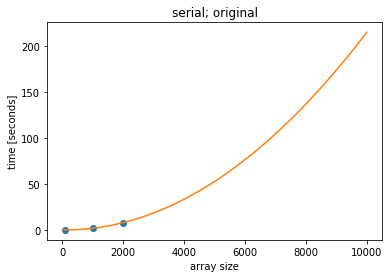

In [18]:
_=plt.plot(x_orig,y_orig,'o', x_orig_filled_in, y_orig_filled_in)
#plt.scatter(x,y)
plt.ylabel('time [seconds]')
plt.xlabel('array size')
plt.title('serial; original')
plt.show()

# _optimization attempt_: replace `for` loop with `list comprehension`
    
According to line profiling, 30% of time is spent in a for loop that could be converted to a lambda function. Let's see what the performance enhancement is due to that change

In [19]:
# https://github.com/nikdon/pyEntropy
def sample_entropy(time_series, sample_length, tolerance=None):
    """Calculate and return Sample Entropy of the given time series.
    Distance between two vectors defined as Euclidean distance and can
    be changed in future releases
    Args:
        time_series: Vector or string of the sample data
        sample_length: Number of sequential points of the time series
        tolerance: Tolerance (default = 0.1...0.2 * std(time_series))
    Returns:
        Vector containing Sample Entropy (float)
    References:
        [1] http://en.wikipedia.org/wiki/Sample_Entropy
        [2] http://physionet.incor.usp.br/physiotools/sampen/
        [3] Madalena Costa, Ary Goldberger, CK Peng. Multiscale entropy analysis
            of biological signals
    """
    if tolerance is None:
        tolerance = 0.1 * np.std(time_series)

    n = len(time_series)
    prev = np.zeros(n)
    curr = np.zeros(n)
    A = np.zeros((sample_length, 1))  # number of matches for m = [1,...,template_length - 1]
    B = np.zeros((sample_length, 1))  # number of matches for m = [1,...,template_length]

    for i in range(n - 1):
        nj = n - i - 1
        ts1 = time_series[i]
        for jj in range(nj):
            j = jj + i + 1
            if abs(time_series[j] - ts1) < tolerance:  # distance between two vectors
                curr[jj] = prev[jj] + 1
                temp_ts_length = min(sample_length, curr[jj])
                for m in range(int(temp_ts_length)):
                    A[m] += 1
                    if j < n - 1:
                        B[m] += 1
            else:
                curr[jj] = 0
#        for j in range(nj):                  # original
#            prev[j] = curr[j]
        prev = [curr[j] for j in range(nj)]   # list comprehension

    N = n * (n - 1) / 2
    B = np.vstack(([N], B[:sample_length - 1]))
    similarity_ratio = A / B
    se = - np.log(similarity_ratio)
    se = np.reshape(se, -1)
    return se

In [20]:
a = np.random.rand(1, 100)[0]
%lprun -f sample_entropy sample_entropy(a, 4, 0.1 * np.std(a))

Timer unit: 1e-06 s

Total time: 0.868672 s
File: <ipython-input-19-b22d432b03f8>
Function: sample_entropy at line 2

Line #      Hits         Time  Per Hit   % Time  Line Contents
     2                                           def sample_entropy(time_series, sample_length, tolerance=None):
     3                                               """Calculate and return Sample Entropy of the given time series.
     4                                               Distance between two vectors defined as Euclidean distance and can
     5                                               be changed in future releases
     6                                               Args:
     7                                                   time_series: Vector or string of the sample data
     8                                                   sample_length: Number of sequential points of the time series
     9                                                   tolerance: Tolerance (default = 0.1...0.2 * 

In [21]:
num_tests=3
serial_lambda_timing_dict={}
serial_lambda_reslt_dict={}
for arry_size in [100,1000,2000]:#,5000,10000]:
    reslt_ary=[]
    for test_indx in range(num_tests):
        a = np.random.rand(1, arry_size)[0]
        start_time = time.time()
        outp=sample_entropy(a, 4, 0.1 * np.std(a))
        elapsed_time = time.time() - start_time
        serial_lambda_reslt_dict[(arry_size,test_indx)]=outp
        print(arry_size,':',elapsed_time,'seconds')
        reslt_ary.append(elapsed_time)
    serial_lambda_timing_dict[arry_size]=sum(reslt_ary)/num_tests

100 : 0.036867618560791016 seconds
100 : 0.02622818946838379 seconds
100 : 0.039716482162475586 seconds
1000 : 3.22453236579895 seconds
1000 : 1.9261791706085205 seconds
1000 : 1.6360185146331787 seconds
2000 : 7.010653257369995 seconds
2000 : 9.492819786071777 seconds
2000 : 9.012346029281616 seconds


In [22]:
serial_lambda_timing_dict

{100: 0.0342707633972168, 1000: 2.2622433503468833, 2000: 8.505273024241129}

--> Slightly faster, but not significant

In [23]:
x_lambda,y_lambda=zip(*serial_lambda_timing_dict.items())

In [24]:
z_lambda = np.polyfit(x_lambda, y_lambda, 2)
f_lambda = np.poly1d(z_lambda)
print('f =\n',f_lambda)
x_lambda_filled_in = np.linspace(0, 10000, 50)
y_lambda_filled_in = f_lambda(x_lambda_filled_in)

f =
            2
1.983e-06 x + 0.0002943 x - 0.01499


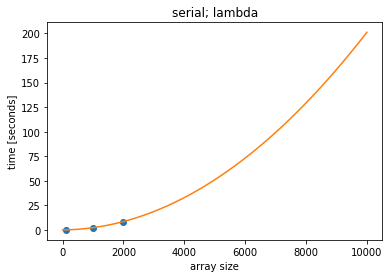

In [25]:
_=plt.plot(x_lambda,y_lambda,'o', x_lambda_filled_in, y_lambda_filled_in)
#plt.scatter(x,y)
plt.ylabel('time [seconds]')
plt.xlabel('array size')
plt.title('serial; lambda')
plt.show()

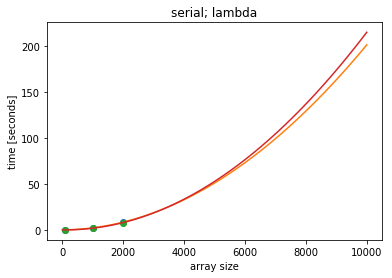

In [26]:
_=plt.plot(x_lambda,y_lambda,'o', x_lambda_filled_in, y_lambda_filled_in)
_=plt.plot(x_orig,y_orig,'o', x_orig_filled_in, y_orig_filled_in)
#plt.scatter(x,y)
plt.ylabel('time [seconds]')
plt.xlabel('array size')
plt.title('serial; lambda')
plt.show()

_Side note; this path is not explored_:<BR>
as far as I understand, in order to use joblib, need to change the for loop to a generator:<BR>
https://joblib.readthedocs.io/en/latest/parallel.html#parallel<BR>
"The core idea is to write the code to be executed as a generator expression, and convert it to parallel computing

## compare output of original and lambda-based

--> I don't know how to interpret the outputs, so I don't know whether the comparisons are acceptable

In [27]:
serial_original_reslt_dict

{(100, 0): array([ 2.82356309,  3.16758253,         inf,         nan]),
 (100, 1): array([ 2.85465368,  3.15344802,         inf,         nan]),
 (100, 2): array([ 2.8201675 ,  2.62535849,  2.35137526,         inf]),
 (1000, 0): array([ 2.86640892,  2.85354844,  2.92981349,  2.85647021]),
 (1000, 1): array([ 2.86507287,  2.86675204,  2.95379358,  2.82137889]),
 (1000, 2): array([ 2.8747822 ,  2.85706039,  2.87499157,  2.55389952]),
 (2000, 0): array([ 2.86431793,  2.86475101,  2.83971089,  2.84649375]),
 (2000, 1): array([ 2.85670575,  2.85752347,  2.87304813,  2.87437142]),
 (2000, 2): array([ 2.88204633,  2.88014463,  2.89484461,  2.9048858 ])}

In [28]:
serial_lambda_reslt_dict

{(100, 0): array([ 2.86878819,  2.9267394 ,  1.60943791,         inf]),
 (100, 1): array([ 3.00588465,  3.08274365,  2.39789527,         inf]),
 (100, 2): array([ 2.89401475,  2.76149804,  2.83321334,         inf]),
 (1000, 0): array([ 2.88104601,  2.90894725,  3.21821987,  4.11087386]),
 (1000, 1): array([ 2.87609577,  2.85298749,  2.80397862,  2.79320801]),
 (1000, 2): array([ 2.86205575,  2.87594692,  2.81341072,  3.17805383]),
 (2000, 0): array([ 2.85218864,  2.85933748,  2.95663983,  2.84199817]),
 (2000, 1): array([ 2.86149703,  2.85567187,  2.89189685,  2.80611141]),
 (2000, 2): array([ 2.8822696 ,  2.88804122,  2.87538184,  3.0881975 ])}

# optimization attempt: fine-grain concurrency: Numba
### Numba = JIT compiler that translates Python and NumPy code into machine code

https://numba.pydata.org/numba-doc/dev/user/performance-tips.html

https://numba.pydata.org/numba-doc/latest/user/parallel.html
https://numba.pydata.org/numba-doc/latest/user/jit.html#parallel-jit-option

In [29]:
import numba as nb

In [30]:
print(nb.__version__)

0.38.1


In [31]:
# https://numba.pydata.org/numba-doc/dev/reference/envvars.html#numba-envvars
import os

# If set to non-zero, printout of Numba warnings is enabled, otherwise the warnings are suppressed. The warnings can give insight into the compilation process.
os.environ["NUMBA_WARNINGS"] = "1"


I recommend playing around with the various arguments to figure out which combination is best

https://realpython.com/primer-on-python-decorators/<BR>
https://www.geeksforgeeks.org/decorators-in-python/

In [32]:
# this is the only modification to the function -- use of a decorator
@nb.jit(fastmath=True,error_model='numpy',parallel=True,nopython=True)
def sample_entropy(time_series, sample_length, tolerance=None):
    """Calculate and return Sample Entropy of the given time series.
    Distance between two vectors defined as Euclidean distance and can
    be changed in future releases
    Args:
        time_series: Vector or string of the sample data
        sample_length: Number of sequential points of the time series
        tolerance: Tolerance (default = 0.1...0.2 * std(time_series))
    Returns:
        Vector containing Sample Entropy (float)
    References:
        [1] http://en.wikipedia.org/wiki/Sample_Entropy
        [2] http://physionet.incor.usp.br/physiotools/sampen/
        [3] Madalena Costa, Ary Goldberger, CK Peng. Multiscale entropy analysis
            of biological signals
    """
    if tolerance is None:
        tolerance = 0.1 * np.std(time_series)

    n = len(time_series)
    prev = np.zeros(n)
    curr = np.zeros(n)
    A = np.zeros((sample_length))  # number of matches for m = [1,...,template_length - 1]
    B = np.zeros((sample_length))  # number of matches for m = [1,...,template_length]

    for i in range(n - 1):
        nj = n - i - 1
        ts1 = time_series[i]
        for jj in range(nj):
            j = jj + i + 1
            if abs(time_series[j] - ts1) < tolerance:  # distance between two vectors
                curr[jj] = prev[jj] + 1
                temp_ts_length = min(sample_length, curr[jj])
                for m in range(int(temp_ts_length)):
                    A[m] += 1
                    if j < n - 1:
                        B[m] += 1
            else:
                curr[jj] = 0
        for j in range(nj):
            prev[j] = curr[j]

    N = n * (n - 1) // 2

    B2=np.empty(sample_length)
    B2[0]=N
    B2[1:]=B[:sample_length - 1]
    similarity_ratio = A / B2
    se = - np.log(similarity_ratio)
    return se

In [33]:
num_tests=3
numba_reslt_dict={}
for arry_size in [100,1000,5000,10000,50000,100000]:
    reslt_ary=[]
    for test_indx in range(num_tests):
        a = np.random.rand(1, arry_size)[0]
        start_time = time.time()
        sample_entropy(a, 4, 0.1 * np.std(a))
        elapsed_time = time.time() - start_time
        print(arry_size,':',elapsed_time,'seconds')
        reslt_ary.append(elapsed_time)
    numba_reslt_dict[arry_size]=sum(reslt_ary)/num_tests

100 : 3.68548321723938 seconds
100 : 0.001340627670288086 seconds
100 : 0.00193023681640625 seconds
1000 : 0.004257678985595703 seconds
1000 : 0.004009723663330078 seconds
1000 : 0.004909515380859375 seconds
5000 : 0.05196404457092285 seconds
5000 : 0.050794363021850586 seconds
5000 : 0.05696558952331543 seconds
10000 : 0.22883081436157227 seconds
10000 : 0.19911932945251465 seconds
10000 : 0.1874253749847412 seconds
50000 : 5.500528812408447 seconds
50000 : 6.658973693847656 seconds
50000 : 7.175236463546753 seconds
100000 : 30.381749629974365 seconds
100000 : 22.80451989173889 seconds
100000 : 22.662930011749268 seconds


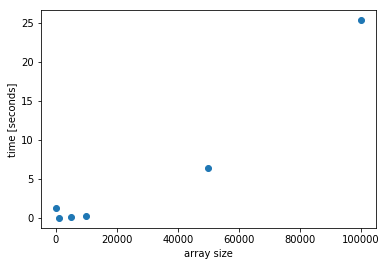

In [34]:
x_numba,y_numba=zip(*numba_reslt_dict.items())
plt.scatter(x_numba,y_numba)
plt.ylabel('time [seconds]')
plt.xlabel('array size')
plt.show()

In [35]:
z_numba = np.polyfit(x_numba, y_numba, 2)

In [36]:
f_numba = np.poly1d(z_numba)
print(f_numba)

           2
2.635e-09 x - 1.41e-05 x + 0.3816


In [38]:
x_numba_filled_in = np.linspace(0, 100000, 50)
y_numba_filled_in = f_numba(x_numba_filled_in)

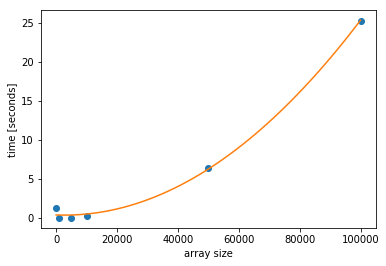

In [39]:
_=plt.plot(x_numba,y_numba,'o', x_numba_filled_in, y_numba_filled_in)
_=plt.ylabel('time [seconds]')
_=plt.xlabel('array size')

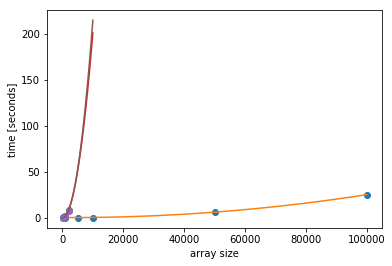

In [40]:
_=plt.plot(x_numba,y_numba,'o', x_numba_filled_in, y_numba_filled_in)
_=plt.plot(x_lambda,y_lambda,'o', x_lambda_filled_in, y_lambda_filled_in)
_=plt.plot(x_orig,y_orig,'o', x_orig_filled_in, y_orig_filled_in)
_=plt.ylabel('time [seconds]')
_=plt.xlabel('array size')

In [41]:
x=18000000 # array size
print((2.092e-09*x*x) - (5.401e-06*x) + 0.01703,'seconds')

677710.7990299999 seconds


677710.7990299999 seconds = 8 days

In [42]:
x=30000 # array size
print((2.092e-09*x*x) - (5.401e-06*x) + 0.01703,'seconds')

1.7377999999999998 seconds
